In [44]:
import os
import nltk
import pickle
import numpy as np
from PIL import Image
from collections import Counter
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
from tqdm import tqdm
import time

import torch
import torch.nn as nn
import torch.utils.data as data
from torchvision import transforms
import torchvision.models as models
import torchvision.transforms as transforms
from torch.nn.utils.rnn import pack_padded_sequence

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.is_available()

True

### Tokenize -> Vocabuly Dictionary

In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to C:\Users\Hoesu
[nltk_data]     Chun\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
class Vocab:
    def __init__(self):
        self.w2i = {}
        self.i2w = {}
        self.index = 0
    
    def __call__(self, token):
        if not token in self.w2i:
            return self.w2i['<unk>']
        return self.w2i[token]
    
    def __len__(self):
        return len(self.w2i)
    
    def add_token(self, token):
        if not token in self.w2i:
            self.w2i[token] = self.index
            self.i2w[self.index] = token
            self.index += 1

In [5]:
def build_vocabulary(json, threshold):
    coco = COCO(json)
    counter = Counter()
    ids = coco.anns.keys()
    for i, id in enumerate(ids):
        caption = str(coco.anns[id]['caption'])
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        counter.update(tokens)
        
    tokens = [token for token, cnt in counter.items() if cnt >= threshold]
    
    vocab = Vocab()
    vocab.add_token('<pad>')
    vocab.add_token('<start>')
    vocab.add_token('<end>')
    vocab.add_token('<unk>')
    
    for i, token in enumerate(tokens):
        vocab.add_token(token)
    return vocab

In [6]:
vocab_path = './data_dir/vocabulary.pkl'
if not os.path.exists(vocab_path):
    vocab = build_vocabulary(json='data_dir/annotations/captions_train2014.json', threshold=4)
    with open(vocab_path, 'wb') as f:
        pickle.dump(vocab, f)
    print("Total vocabulary size: {}".format(len(vocab)))
    print("Saved the vocabulary wrapper to '{}'".format(vocab_path))
else:
    print('Vocabulary wrapper already created.')

Vocabulary wrapper already created.


### Resize Image

In [7]:
def reshape_image(image, shape):
    """Resize an image to the given shape."""
    return image.resize(shape, Image.ANTIALIAS)
 
def reshape_images(image_path, output_path, shape):
    """Reshape the images in 'image_path' and save into 'output_path'."""
    if not os.path.exists(output_path):
        os.makedirs(output_path)
 
    images = os.listdir(image_path)
    num_im = len(images)
    for i, im in enumerate(images):
        with open(os.path.join(image_path, im), 'r+b') as f:
            with Image.open(f) as image:
                image = reshape_image(image, shape)
                image.save(os.path.join(output_path, im), image.format)
        if (i+1) % 20000 == 0:
            print ("[{}/{}] Resized the images and saved into '{}'."
                   .format(i+1, num_im, output_path))

train_image_path = './data_dir/train2014/'
train_output_path = './data_dir/resized_images/train2014/'
val_image_path = './data_dir/val2014/'
val_output_path = './data_dir/resized_images/val2014/'
image_shape = [256, 256]
if not os.path.exists(train_output_path):
    reshape_images(train_image_path, train_output_path, image_shape)
    reshape_images(val_image_path, val_output_path, image_shape)
else:
    print('Images are already resized.')

Images are already resized.


In [8]:
class CustomCocoDataset(data.Dataset):
    
    def __init__(self, data_path, coco_json_path, vocabulary, transform=None):
        self.root = data_path
        self.coco_data = COCO(coco_json_path)
        self.indices = list(self.coco_data.anns.keys())
        self.vocabulary = vocabulary
        self.transform = transform
 
    def __getitem__(self, idx):
        coco_data = self.coco_data
        vocabulary = self.vocabulary
        annotation_id = self.indices[idx]
        caption = coco_data.anns[annotation_id]['caption']
        image_id = coco_data.anns[annotation_id]['image_id']
        image_path = coco_data.loadImgs(image_id)[0]['file_name']
 
        image = Image.open(os.path.join(self.root, image_path)).convert('RGB')
        if self.transform is not None:
            image = self.transform(image)
        else:
            transform = transforms.Compose([transforms.ToTensor()])
            image = transform(image)
 
        word_tokens = nltk.tokenize.word_tokenize(str(caption).lower())
        caption = []
        caption.append(vocabulary('<start>'))
        caption.extend([vocabulary(token) for token in word_tokens])
        caption.append(vocabulary('<end>'))
        ground_truth = torch.Tensor(caption)
        return image, ground_truth
 
    def __len__(self):
        return len(self.indices)

In [9]:
def collate_function(data_batch):
    '''
    creates mini-batch tensors from the list of tuples (image, caption)
    '''
    data_batch.sort(key=lambda x: len(x[1]), reverse=True)
    imgs, caps = zip(*data_batch)
    
    # list of 3D tensor -> 4D tensor (image)
    imgs = torch.stack(imgs, 0)
    
    # list of 1D tensor -> 2D tensor (caption)
    cap_lens = [len(cap) for cap in caps]
    tgts = torch.zeros(len(caps), max(cap_lens)).long()
    for i, cap in enumerate(caps):
        end = cap_lens[i]
        tgts[i, :end] = cap[:end]
    return imgs, tgts, cap_lens

In [10]:
def get_loader(data_path, coco_json_path, vocabulary, transform, batch_size, shuffle, num_workers):
    coco_dataser = CustomCocoDataset(data_path=data_path,
                       coco_json_path=coco_json_path,
                       vocabulary=vocabulary,
                       transform=transform)
    custom_data_loader = torch.utils.data.DataLoader(dataset=coco_dataser, 
                                              batch_size=batch_size,
                                              shuffle=shuffle,
                                              num_workers=num_workers,
                                              collate_fn=collate_function)
    return custom_data_loader

In [11]:
'''
Custom Data Loader Unit Test
'''
with open('data_dir/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)

train_data_loader = get_loader('data_dir/resized_images/train2014/', 'data_dir/annotations/captions_train2014.json', vocabulary, 
                         None, 4, shuffle=False, num_workers=0) 

for i, (imgs, capts, lens) in enumerate(train_data_loader):
    print('image shape: ', imgs.shape)
    print('caption shape: ', capts.shape)
    print('lens: ', lens)
    break

loading annotations into memory...
Done (t=0.81s)
creating index...
index created!
image shape:  torch.Size([4, 3, 256, 256])
caption shape:  torch.Size([4, 14])
lens:  [14, 13, 11, 10]


In [12]:
class CNNModel(nn.Module):
    def __init__(self, embedding_size):
        super(CNNModel, self).__init__()
        resnet = models.resnet152(pretrained=True)
        module_list = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet_module = nn.Sequential(*module_list)
        self.linear_layer = nn.Linear(resnet.fc.in_features, embedding_size)
        self.batch_norm = nn.BatchNorm1d(embedding_size, momentum=0.01)
        
    def forward(self, input_images):
        with torch.no_grad():
            resnet_features = self.resnet_module(input_images)
        # shape: (batch_size, 2048, 1, 1)
        resnet_features = resnet_features.reshape(resnet_features.size(0), -1)
        # shape: (batch_size, 2048)
        final_features = self.batch_norm(self.linear_layer(resnet_features))
        # shape: (batch_size, embedding_size)
        return final_features

In [13]:
'''
CNN Encoder Unit Test
'''
random_img = torch.rand(1, 3, 256, 256).to(device)
model = CNNModel(256).to(device)
model.eval()
model(random_img).shape

torch.Size([1, 256])

In [14]:
class LSTMModel(nn.Module):
    
    def __init__(self, embedding_size, hidden_layer_size, vocabulary_size, num_layers, max_seq_len=20):
        super().__init__()
        self.embedding_layer = nn.Embedding(vocabulary_size, embedding_size)
        self.lstm_layer = nn.LSTM(embedding_size, hidden_layer_size, num_layers, batch_first=True)
        self.linear_layer = nn.Linear(hidden_layer_size, vocabulary_size)
        self.max_seq_len = max_seq_len
        
    def forward(self, input_features, capts, lens):
        # capts: (batch, length)
        embeddings = self.embedding_layer(capts)
        # embeddings: (batch, length, embedding_size)
        embeddings = torch.cat((input_features.unsqueeze(1), embeddings), 1)
        lstm_input = pack_padded_sequence(embeddings, lens, batch_first=True)
        # lstm_input: (batch*length, embedding_size)
        # note: even though input_features is concatenated, we do not increase lens by 1 to discard the last word, <end>.
        hidden_variables, _ = self.lstm_layer(lstm_input)
        # hidden_variables[0]: (batch*length, hidden_layer_size)
        model_outputs = self.linear_layer(hidden_variables[0])
        # model_outputs: (batch*length, vocabulary_size)
        return model_outputs
    
    def sample(self, input_features, lstm_states=None):
        sampled_indices = []
        lstm_inputs = input_features.unsqueeze(1)
        for i in range(self.max_seq_len):
            hidden_variables, lstm_states = self.lstm_layer(lstm_inputs, lstm_states)
            # hidden_variables: (batch, 1, hidden_size)
            model_outputs = self.linear_layer(hidden_variables.squeeze(1))
            # model_outputs: (batch, vocbulary_size)
            _, predicted_outputs = model_outputs.max(1)
            sampled_indices.append(predicted_outputs)
            lstm_inputs = self.embedding_layer(predicted_outputs)
            lstm_inputs = lstm_inputs.unsqueeze(1)
        sampled_indices = torch.stack(sampled_indices, 1)
        return sampled_indices

In [15]:
'''
LSTM Decoder Unit Test
'''
random_features = torch.rand(4, 256).long().to(device)
random_capts = torch.zeros(4, 14).int().to(device)
lens = [14] * 4
model = LSTMModel(256, 512, len(vocabulary), 1).to(device)
model.eval()
output = model(random_features, random_capts, lens)
print(output.shape)

torch.Size([56, 9948])


In [16]:
'''
LSTM Decoder Sample Unit Test
'''
random_feature = torch.rand(1, 256).to(device)
model = LSTMModel(256, 512, len(vocabulary), 1).to(device)
model.sample(random_feature)

tensor([[ 973, 8225, 7294, 6186, 5759, 5126, 6240, 2345, 4824, 5931, 5912, 4631,
         2310, 9052, 9671,  116, 2663, 2030, 7687, 3240]], device='cuda:0')

## Hyper Parameters

In [17]:
transform = transforms.Compose([ 
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])

batch_size = 128
embedding_size = 256
lstm_hidden_size = 512
lstm_num_layers = 1
lr = 1e-3
epochs = 10

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if not os.path.exists('models_dir/'):
    os.makedirs('models_dir/')
    
with open('data_dir/vocabulary.pkl', 'rb') as f:
    vocabulary = pickle.load(f)

train_data_loader = get_loader('data_dir/resized_images/train2014/', 'data_dir/annotations/captions_train2014.json', vocabulary, 
                         transform=transform, batch_size=batch_size,
                         shuffle=True, num_workers=0)

val_data_loader = get_loader('data_dir/resized_images/val2014/', 'data_dir/annotations/captions_val2014.json', vocabulary,
                         transform=None, batch_size=batch_size,
                         shuffle=True, num_workers=0)

encoder = CNNModel(embedding_size).to(device)
decoder = LSTMModel(embedding_size, lstm_hidden_size, len(vocabulary), lstm_num_layers).to(device)

loss_fn = nn.CrossEntropyLoss()
params = list(encoder.linear_layer.parameters()) + list(encoder.batch_norm.parameters()) + list(decoder.parameters())
optimizer = torch.optim.Adam(params, lr=lr)

train_losses = []
val_losses = []

loading annotations into memory...
Done (t=0.71s)
creating index...
index created!
loading annotations into memory...
Done (t=0.43s)
creating index...
index created!


In [19]:
encoder.eval()
decoder.eval()
with torch.no_grad():
    loss = 0
    for i, (imgs, capts, lens) in enumerate(train_data_loader):
        imgs = imgs.to(device)
        capts = capts.to(device)
        tgts = pack_padded_sequence(capts, lens, batch_first=True)[0]
        features = encoder(imgs)
        outputs = decoder(features, capts, lens)
        loss += loss_fn(outputs, tgts)
        break
print(f'Initial train loss: {loss:.4f}')

Initial train loss: 9.2119


In [20]:
def eval_model(data='val', single_batch=True):
    assert data == 'train' or data == 'val', 'data should be either \'train\' or \'val\''
    data_loader = val_data_loader if data == 'val' else train_data_loader
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        cnt = 0
        loss = 0
        for i, (imgs, capts, lens) in enumerate(data_loader):
            imgs = imgs.to(device)
            capts = capts.to(device)
            tgts = pack_padded_sequence(capts, lens, batch_first=True)[0]
            features = encoder(imgs)
            outputs = decoder(features, capts, lens)
            cnt += len(imgs)
            loss += loss_fn(outputs, tgts)
            if single_batch:
                break
        loss /= cnt
    return loss

In [21]:
def train_model(epochs):
    num_steps = len(train_data_loader)
    for epoch in range(epochs):
        with tqdm(total=100) as bar:
            for i, (imgs, capts, lens) in enumerate(train_data_loader):
                encoder.train()
                decoder.train()
                imgs = imgs.to(device)
                capts = capts.to(device)
                # tgts: (batch * t,)
                tgts = pack_padded_sequence(capts, lens, batch_first=True)[0]
                features = encoder(imgs)
                # outputs: (batch * t, len(vocabulary))
                outputs = decoder(features, capts, lens)
                loss = loss_fn(outputs, tgts)
                encoder.zero_grad()
                decoder.zero_grad()
                loss.backward()
                optimizer.step()
                
                val_loss = eval_model(data='val')
                train_losses.append(loss/len(imgs))
                val_losses.append(val_loss)
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f},'
                          'Validation Loss: {:.4f}'.format(epoch+1, epochs, i+1, num_steps, loss/len(imgs), val_loss))
                
                if (i+1) % 600 == 0:
                    torch.save({
                        'epoch': epoch+1,
                        'encoder': encoder.state_dict(),
                        'decoder': decoder.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'loss': loss,
                    }, os.path.join('models_dir/', 'epoch-{}, step-{}'.format(epoch+1, i+1)))
                
                bar.update(100/num_steps)

In [22]:
def retrain_model(epochs, path):
    checkpoint = torch.load(path)
    prev_epoch = checkpoint['epoch']
    encoder.load_state_dict(checkpoint['encoder'])
    decoder.load_state_dict(checkpoint['decoder'])
    optimizer.load_state_dict(checkpoint['optimizer'])
    loss = checkpoint['loss']
    
    num_steps = len(train_data_loader)
    for epoch in range(prev_epoch, prev_epoch+epochs):
        with tqdm(total=100) as bar:
            for i, (imgs, capts, lens) in enumerate(train_data_loader):
                encoder.train()
                decoder.train()
                imgs = imgs.to(device)
                capts = capts.to(device)
                # tgts: (batch * t,)
                tgts = pack_padded_sequence(capts, lens, batch_first=True)[0]
                features = encoder(imgs)
                # outputs: (batch * t, len(vocabulary))
                outputs = decoder(features, capts, lens)
                loss = loss_fn(outputs, tgts)
                encoder.zero_grad()
                decoder.zero_grad()
                loss.backward()
                optimizer.step()
                
                val_loss = eval_model(data='val')
                train_losses.append(loss/len(imgs))
                val_losses.append(val_loss)
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f},'
                          'Validation Loss: {:.4f}'.format(epoch+1, epochs, i+1, num_steps, loss/len(imgs), val_loss))
                
                if (i+1) % 600 == 0:
                    torch.save({
                        'epoch': epoch+1,
                        'encoder': encoder.state_dict(),
                        'decoder': decoder.state_dict(),
                        'optimizer': optimizer.state_dict(),
                        'loss': loss,
                    }, os.path.join('models_dir/', 'epoch-{}, step-{}'.format(epoch+1, i+1)))
                
                bar.update(100/num_steps)

In [23]:
def plot_loss():
    plt.figure(figsize=(10,5))
    plt.title("Train and Validation Loss")
    plt.plot(train_losses,label="train")
    plt.plot(val_losses,label="val")
    plt.xlabel("iterations")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

## Training

In [ ]:
train_model(epochs)

In [ ]:
plot_loss()

## Sampling

In [55]:
def load_model(path):
    encoder = CNNModel(embedding_size).eval()
    decoder = LSTMModel(embedding_size, lstm_hidden_size, len(vocabulary), lstm_num_layers).eval()
    encoder = encoder.to(device)
    decoder = decoder.to(device)
    checkpoint = torch.load(path)
    encoder.load_state_dict(checkpoint['encoder'])
    decoder.load_state_dict(checkpoint['decoder'])
    return encoder, decoder
encoder, decoder = load_model('./models_dir/epoch-5, step-3000')

In [56]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])

In [57]:
def load_image(image_path, transform=None):
    img = Image.open(image_path).convert('RGB')
    img = img.resize([224, 244], Image.LANCZOS)
    if transform is not None:
        img = transform(img).unsqueeze(0)
    else:
        transform = transforms.Compose([transforms.ToTensor()])
        img = transform(img).unsqueeze(0)
    return img

In [58]:
def sample_image(image_path):
    img = load_image(image_path).to(device)
    feature = encoder(img)
    indices = decoder.sample(feature)
    # (1, max_seq_length) -> (max_seq_length)
    indices = indices[0].cpu().numpy()
    caption = []
    for index in indices:
        word = vocabulary.i2w[index]
        caption.append(word)
        if word == '<end>':
            break
    return ' '.join(caption)    

<start> a woman sitting on a couch with a laptop . <end>


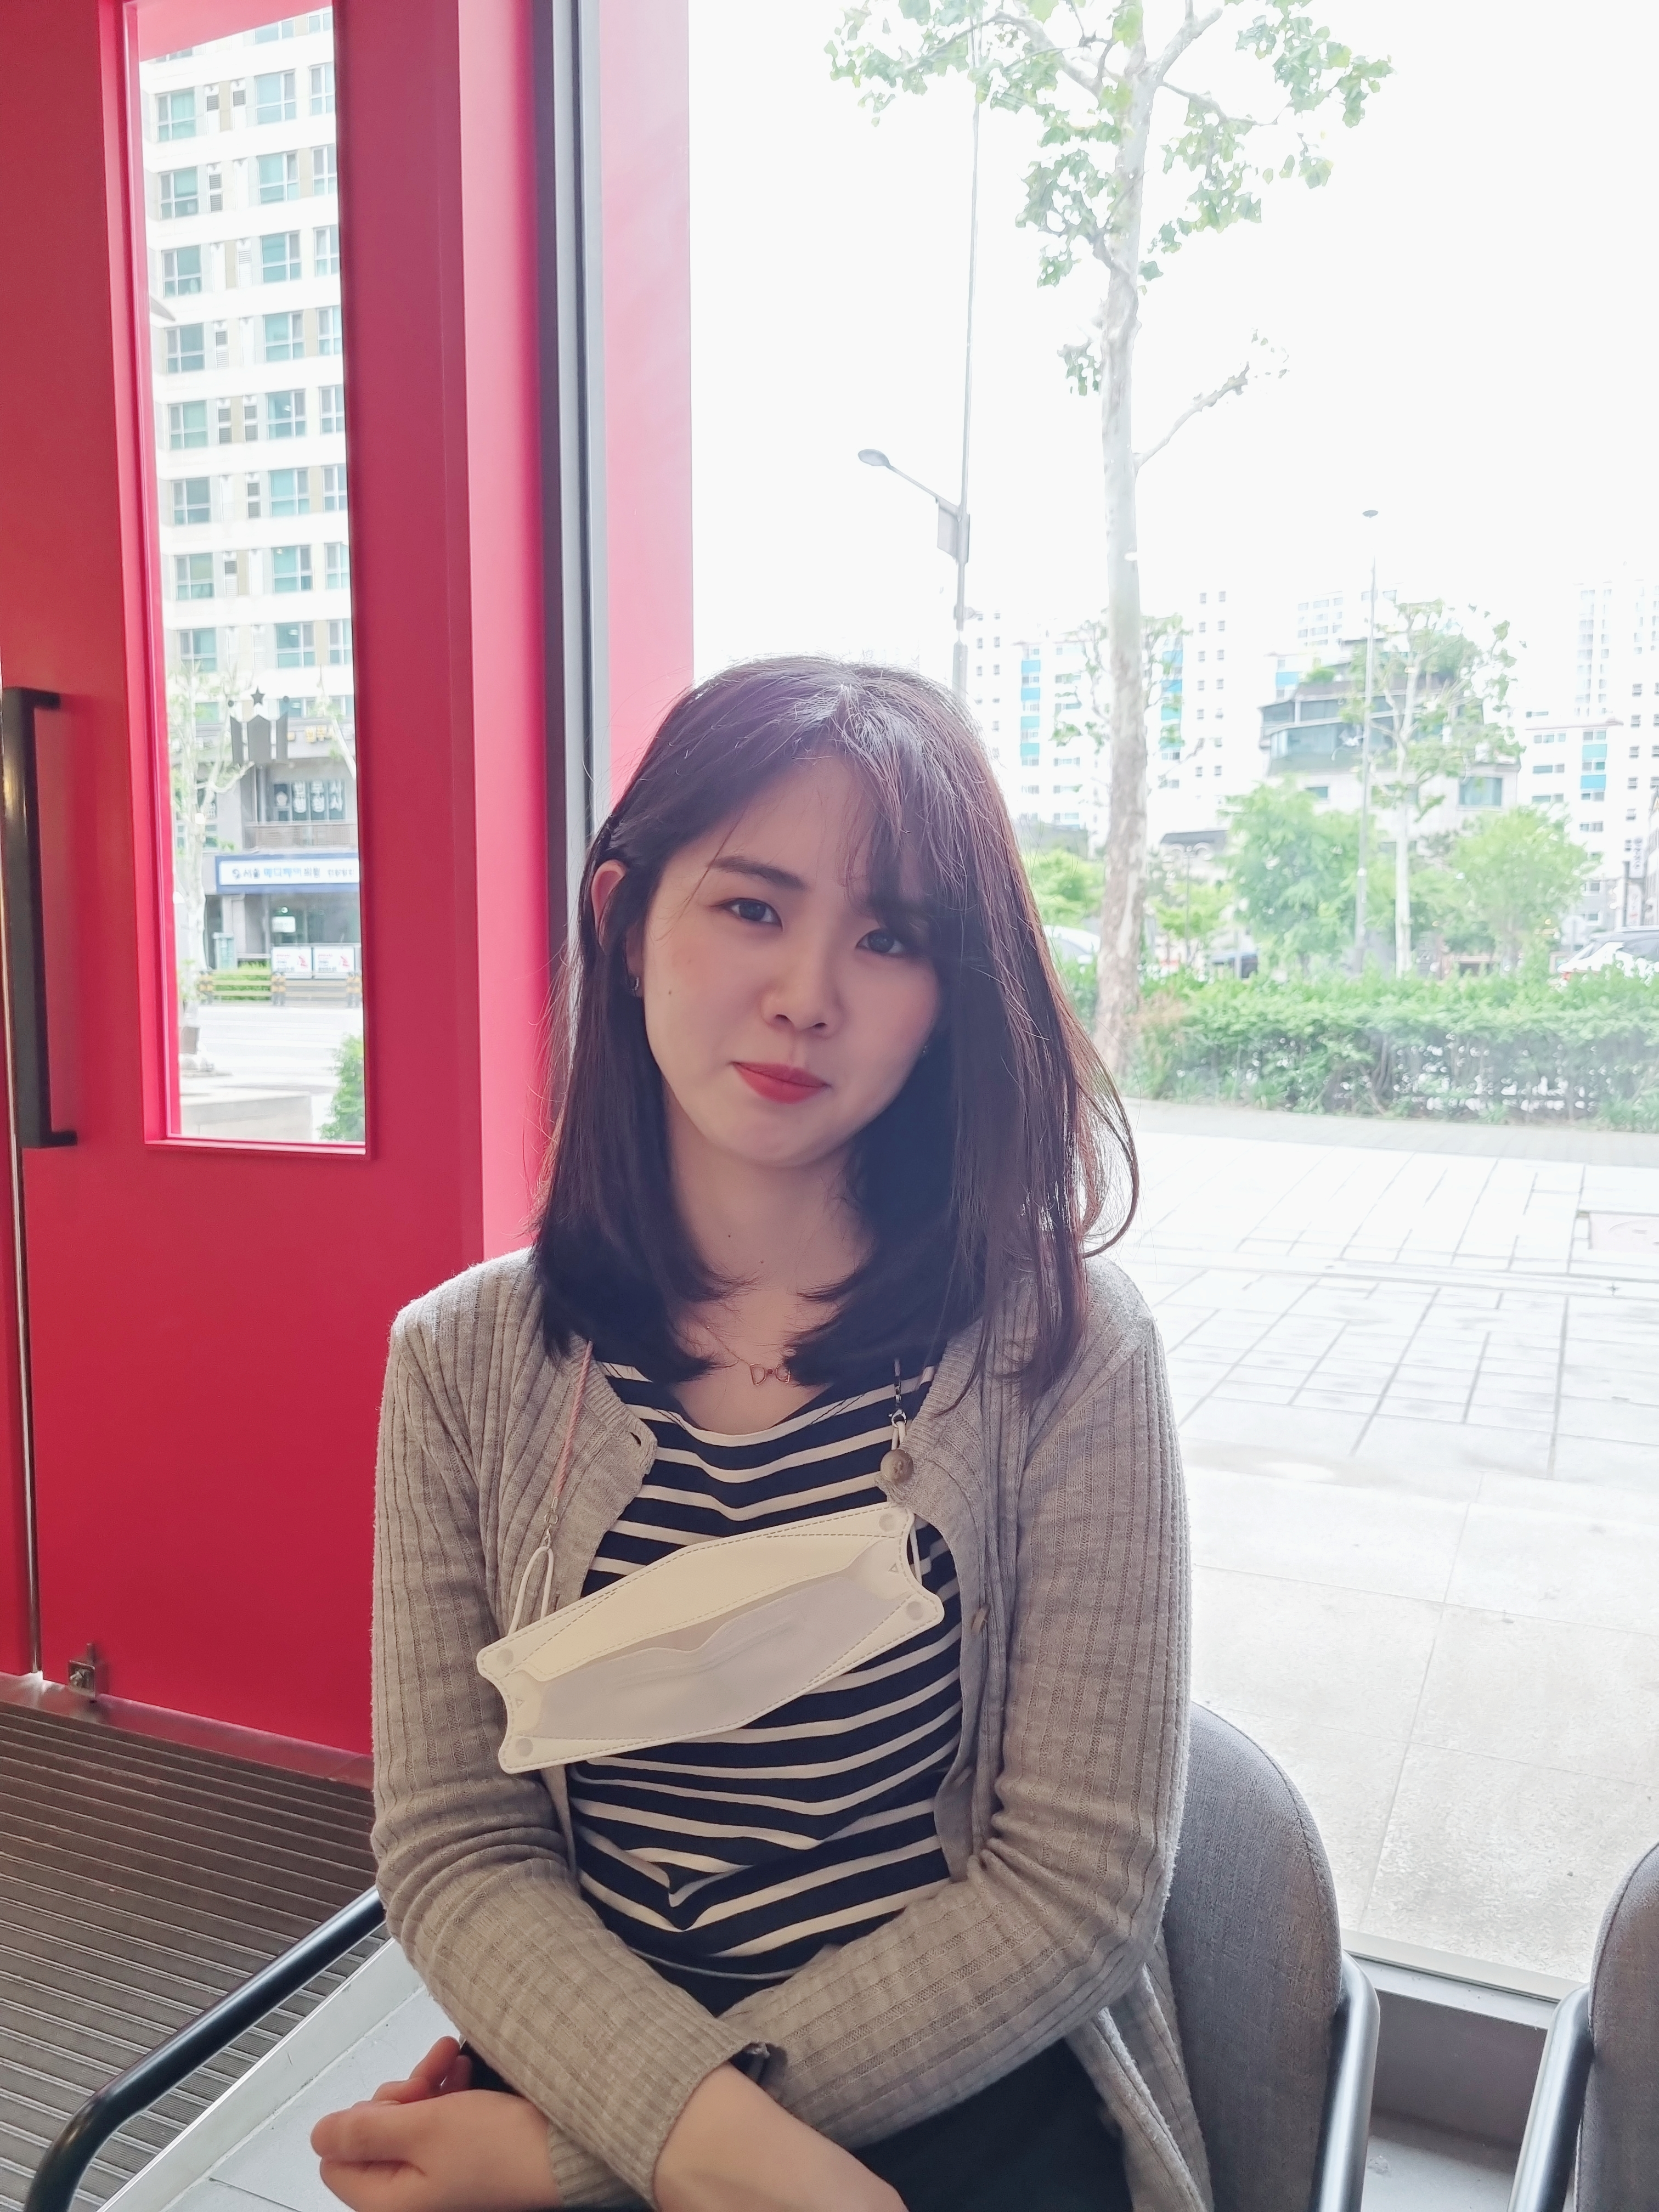

In [59]:
image_path = 'sample2.jpg'
print(sample_image(image_path))
from IPython.display import Image as display
display(filename=image_path, width=256, height=256)